In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, defaultdict

In [91]:
# DAG provided in appendix A
dag = {
    (1, 31), (2, 1), (3, 8), (4, 3), (5, 2), (6, 16), (7, 6), (8, 7), (9, 8), (10, 9), (11, 1), (12, 5), (13, 12), (14, 13), (15, 11), (16, 5), (17, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 18), (22, 21), (23, 22), (24, 5), (25, 24), (26, 25), (27, 26), (28, 26), (29, 27), (29, 28), (30, 4), (30, 10), (30, 14), (30, 20), (30, 23), (30, 29)
}

# processing times provided in Appendix A
p = [3, 10, 2, 2, 5, 2, 14, 5, 6, 5, 5, 2, 3, 3, 5, 6, 6, 6, 2, 3, 2, 3, 14, 5, 18, 10, 2, 3, 6, 2, 10]

test_p = [1, 3, 5]

# due dates provided in Appendix A
d = [172, 82, 18, 61, 93, 71, 217, 295, 290, 287, 253, 307, 279, 73, 355, 34, 233, 77, 88, 122, 71, 181, 340, 141, 209, 217, 256, 144, 307, 329, 269]

test_d = [4, 3, 6]

num_nodes = len(p)

# initial solution for tabu search algorithm for given DAG
initial_solution = [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]

In [92]:
# finding all nodes that a given node can reach either directly or transitively
def get_all_reachable(dag):
    reachable = set()
    nodes = list(range(num_nodes))

    # marking all nodes reached from a direct edge as reachable
    for (u, v) in dag:
        reachable.add((u, v))

    # Floyd-Warshall algorithm
    for i in nodes:
        for j in nodes:
            for k in nodes:
                # transitive reachability, i.e. if i can reach j & j can reach k, i can reach k 
                if (i, j) in reachable and (j, k) in reachable:
                    reachable.add((i, k))

    return reachable

reachable = get_all_reachable(dag)

In [55]:
def generate_initial_solution(dag):
    # generating an initial solution using a topical sort
    num_edges_into_node = {}
    all_nodes = set(list(range(num_nodes)))
    
    # initializing dictionary
    for node in all_nodes:
        num_edges_into_node[node] = 0
    
    for (u, v) in dag:
        num_edges_into_node[v] += 1
        
    # finding all nodes with no edges into it
    processing_queue = deque([node for node in all_nodes if num_edges_into_node[node] == 0])
    initial_solution = []
    while processing_queue:
        node = processing_queue.popleft()
        initial_solution.append(node)
        
        for (u, v) in dag:
            if u == node:
                num_edges_into_node[v] -= 1
                if num_edges_into_node[v] == 0:
                    processing_queue.append(v)
    
    does_contain_cycles = len(initial_solution) != len(all_nodes)
    if not does_contain_cycles:
        return initial_solution
    else:
        return [] # if there is a cycle, no way to do tabu search

In [6]:
def lcl_rule(dag, processing_times):
    all_schedules = []
    schedule = []
    return schedule, all_schedules

In [137]:
# checking if we can swap two nodes at positions i, j in a schedule where i < j
def is_valid_swap(job_i, job_j, reachable=reachable):
    return (job_i, job_j) not in reachable and (job_j, job_i) not in reachable # if either u depends on v or v depends on u, cannot swap nodes

def generate_neighboring_schedule(schedule, tabu_list, swap_index, reachable=reachable):
    neighboring_schedule = []
    step_counter = 0

    # random swapping neighbor generation, not restricted to adjacent jobs
    # i_list = list(range(num_nodes))
    # random.shuffle(i_list)
    # j_list = list(range(num_nodes))
    # random.shuffle(j_list)
    # 
    # # shuffle lists so we don't overweight swaps early in schedule
    # for i in i_list:
    #     for j in j_list:
    #         job_i, job_j = schedule[i], schedule[j]
    #         if is_valid_swap(job_i, job_j, reachable) and (job_i, job_j) not in tabu_list:
    #             neighboring_schedule = schedule[:]
    #             neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
    #             return neighboring_schedule, (job_i, job_j), i
    # 
    
    while step_counter < len(schedule):
        i, j = swap_index % (len(schedule) - 1), (swap_index + 1) % (len(schedule) - 1)
        job_i, job_j = schedule[i], schedule[j]
        if is_valid_swap(job_i, job_j, reachable) and (job_i, job_j) not in tabu_list:
            neighboring_schedule = schedule[:]
            neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
            return neighboring_schedule, (job_i, job_j), i

        swap_index += 1
        step_counter += 1
                
    # if no valid neighbors, we are done            
    return neighboring_schedule, (-1, -1), -1

def evaluate_tardiness(schedule, p, d):
    total_tardiness = 0
    current_time = 0
    
    for job in schedule:
        completion_time = current_time + p[job-1] # -1 because 0 indexing
        tardiness = max(0, completion_time - d[job-1])
        total_tardiness += tardiness
        current_time = completion_time
    
    return total_tardiness

def tabu_search(dag, p, d, num_iterations=100, tolerance=10, tabu_list_length=20, use_default_initial_solution=True, verbose=False):
    # initializing parameters
    tabu_list = deque(maxlen=tabu_list_length)
    reachable = get_all_reachable(dag)
    current_schedule = initial_solution if use_default_initial_solution else generate_initial_solution(dag)
    current_tardiness = evaluate_tardiness(current_schedule, p, d)
    best_schedule = current_schedule
    best_tardiness = current_tardiness
    swap_index = 0
    start_iter_swap_index = swap_index
    iteration = 0
    while iteration < num_iterations:
        neighbor_schedule, (job_i, job_j), new_swap_index = generate_neighboring_schedule(current_schedule, tabu_list, swap_index, reachable)
        if verbose:
            print("*******************************************************")
            print(f"Iteration: {iteration}")
            print(f"Neighbor: {neighbor_schedule}")
            print(f"Swapped: {(job_i, job_j)}")
            print(f"Tabu List: {tabu_list}")
            print(f"Neighbor Tardiness: {evaluate_tardiness(neighbor_schedule, p, d)}")

        if not neighbor_schedule or new_swap_index + 1 == start_iter_swap_index: # if no valid neighbors or we have looked at all valid swaps with no candidates, we are done
            return best_schedule, best_tardiness
        
        swap_index = new_swap_index + 1 # moving right one to not just swap job back
        neighbor_tardiness = evaluate_tardiness(neighbor_schedule, p, d)
        delta = current_tardiness - neighbor_tardiness
        if delta > -1 * tolerance or neighbor_tardiness < best_tardiness:
            current_schedule, current_tardiness = neighbor_schedule, neighbor_tardiness
            tabu_list.append((job_i, job_j))
            iteration += 1
            start_iter_swap_index = swap_index
            if current_tardiness < best_tardiness:
                best_tardiness = current_tardiness
                best_schedule = current_schedule
    
    return best_schedule, best_tardiness

In [115]:
initial_tardiness = evaluate_tardiness(initial_solution, p, d)
print(initial_tardiness)

341


In [139]:
best_schedule, best_tardiness = tabu_search(dag, p, d, num_iterations=100, verbose=False)
print(best_tardiness)
print(best_schedule)

233
[30, 14, 13, 4, 20, 23, 3, 29, 28, 10, 9, 19, 22, 27, 21, 18, 17, 15, 8, 7, 6, 16, 11, 26, 25, 24, 12, 5, 2, 1, 31]


In [16]:
print(generate_initial_solution(dag))
print(initial_solution)

[29, 13, 19, 22, 28, 3, 9, 12, 18, 21, 27, 26, 2, 8, 11, 20, 25, 7, 17, 24, 6, 16, 23, 5, 14, 15, 10, 4, 1, 0, 30]
[29, 28, 22, 9, 8, 13, 12, 11, 3, 19, 21, 2, 26, 27, 7, 6, 18, 20, 25, 17, 24, 16, 14, 5, 23, 15, 4, 10, 1, 0, 30]


In [152]:
tolerances = [0, 3, 5, 10, 15, 20, 50]
tabu_list_lengths = [5, 10, 20, 50, 100]
num_iters = [10, 100, 1000, 5000, 10000]
samples_to_test = 1

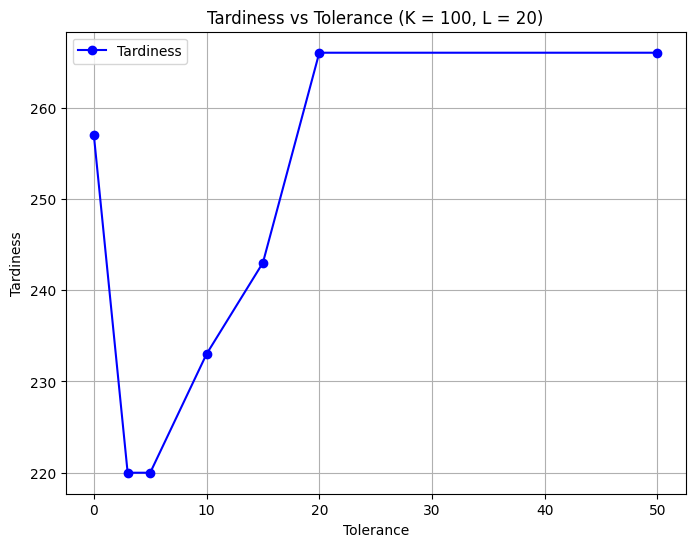

In [149]:
mean_tardiness_at_tolerance = []
std_deviation_tardiness_at_tolerance = []
for tolerance in tolerances:
    best_outcomes = []
    for _ in range(samples_to_test):
        _, best_tardiness = tabu_search(dag, p, d, tolerance=tolerance)
        best_outcomes.append(best_tardiness)
    mean_tardiness_at_tolerance.append(np.array(best_outcomes).mean())
    
plt.figure(figsize=(8, 6))
plt.plot(tolerances, mean_tardiness_at_tolerance, marker='o', color='b', label="Tardiness")
means = np.array(mean_tardiness_at_tolerance)

# Add labels and title
plt.xlabel('Tolerance')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Tolerance (K = 100, L = 20)')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for tabu_len in tabu_list_lengths:
    _, best_tardiness = tabu_search(dag, p, d, tabu_list_length=tabu_len)
    # TODO: plot total tardiness vs tabu list length
    

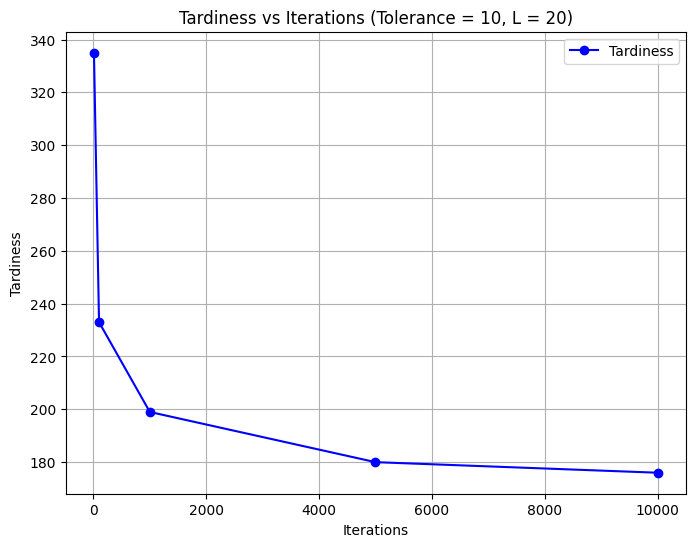

In [153]:
mean_tardiness_at_iter = []
std_deviation_tardiness_at_iter = []
for iter in num_iters:
    best_outcomes = []
    for _ in range(samples_to_test):
        _, best_tardiness = tabu_search(dag, p, d, num_iterations=iter)
        best_outcomes.append(best_tardiness)
    mean_tardiness_at_iter.append(np.array(best_outcomes).mean())

plt.figure(figsize=(8, 6))
plt.plot(num_iters, mean_tardiness_at_iter, marker='o', color='b', label="Tardiness")
means = np.array(mean_tardiness_at_iter)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Iterations (Tolerance = 10, L = 20)')

plt.grid(True)
plt.legend()
plt.show()